# Imports

In [172]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_roc_curve, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

In [154]:
defaults = pd.read_csv("../../data/SVM_exercises/defaults.csv", sep = ";")
defaults_valid = pd.read_csv("../../data/SVM_exercises/defaults_valid.csv", sep = ";")

In [159]:
(defaults["default payment next month"].value_counts()*100/len(defaults)).to_frame().T

,0,1
default payment next month,77.820636,22.179364


**Czy zbiór jest zbalansowany?**

Zbiór jest lekko niezbalansowany - 22% jedynek w klasie decyzyjnej (default payment next month)

**Czy do oceny jakości klasyfikacji modelu korzystniejsza jest w tym przypadku F miara czy “balanced accuracy”?**

F Score vs Balanced Accuracy - przez to, że korzystam z niezbalansowanych danych to do oceny jakości klasyfikacji modeu korzystniejsze jest balanced accuracy. Balanced Accuracy to średnia ze Specifity i Recall. Obydwie te metryki są niewrażliwe na niezbalansowanie zbioru uczącego.

# Data Preprocessing

In [160]:
y = defaults.pop("default payment next month")
X = defaults.copy()
y_valid = defaults_valid.pop("default payment next month")
X_valid = defaults_valid.copy()

scaler = StandardScaler().fit(X)
columns = X.columns
X = pd.DataFrame(scaler.transform(X), columns=columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=columns)

### Dlaczego używam Standard Scalera?

SVM stara się zmaksymalizować odległość między płaszczyzną separacji a wektorami wsparcia. Jeśli jedna cecha (tzn. jeden wymiar w tej przestrzeni) ma bardzo duże wartości, zdominuje ona pozostałe cechy przy obliczaniu odległości. Jeśli zestandaryzujemy wszystkie cechy (np. do średniej 0 i odchylenia 1), to wszystkie one będą miały taki sam wpływ na metrykę odległości.

# Cross Validation

In [161]:
model = SVC()
cv_results = cross_validate(estimator=model, X=X, y=y,
    scoring=["roc_auc", "balanced_accuracy"], cv=3, 
    return_train_score=True
)
cv_results = pd.DataFrame(cv_results)
cv_results.mean().to_frame().T

,fit_time,score_time,test_roc_auc,train_roc_auc,test_balanced_accuracy,train_balanced_accuracy
0,12.12598,15.153625,0.716819,0.800779,0.642024,0.657646


# Confusion Matrix on validation set

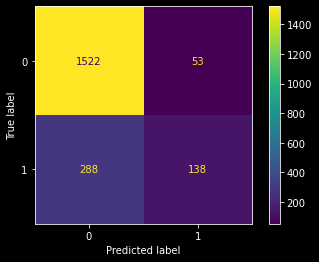

In [162]:
model.fit(X, y)
y_valid_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 
plt.show()

# Permutation Importance

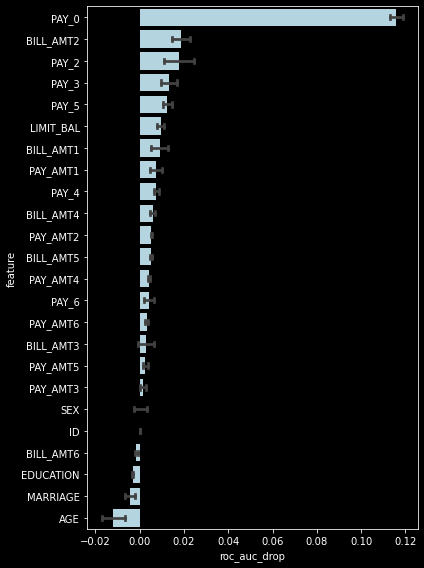

In [163]:
result = permutation_importance(model, X_valid, y_valid, scoring='roc_auc', n_repeats=3, random_state=42)
pi_results_df = pd.DataFrame(result['importances'])
pi_results_df.index=X.columns
pi_results_df = pi_results_df.stack().reset_index()
pi_results_df.columns = ['feature', 'level', 'roc_auc_drop']
pi_results_df.drop(columns=['level'], inplace=True)

fig, ax = plt.subplots(figsize=(6, 8))
order = pi_results_df.groupby("feature").mean().reset_index().sort_values('roc_auc_drop', ascending=False).feature
ax = sns.barplot(x="roc_auc_drop", y="feature", data=pi_results_df, estimator=np.mean, ci=85, capsize=.2, color='lightblue', orient='h', order=order)
fig.tight_layout()
plt.show()

# Dropping Not Important Features

In [199]:
columns_to_drop = pi_results_df.groupby("feature").mean().reset_index().sort_values('roc_auc_drop', ascending=False).tail(10).feature.values
columns_to_drop

array(['PAY_AMT6', 'BILL_AMT3', 'PAY_AMT5', 'PAY_AMT3', 'SEX', 'ID',
       'BILL_AMT6', 'EDUCATION', 'MARRIAGE', 'AGE'], dtype=object)

## Validation ROC AUC all features

C:\Users\Mateusz\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


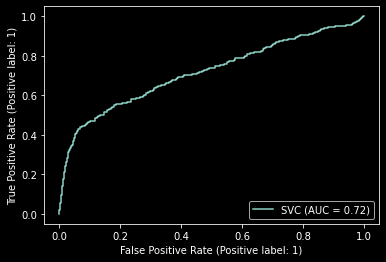

In [191]:
model = SVC()
model.fit(X, y)
plot_roc_curve(model, X_valid, y_valid);

## Validation ROC AUC only important features

In [ ]:
X_dropped = X.drop(columns=columns_to_drop)
X_valid_dropped = X_valid.drop(columns=columns_to_drop)

model = SVC()
model.fit(X_dropped, y)
plot_roc_curve(model, X_valid_dropped, y_valid);

In [198]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)